# Lucas Oliveira Machado de Sousa

# Importation des images

In [1]:
#%% SECTION 1 inclusion de packages externes 

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import circle_level_set
from skimage.segmentation import disk_level_set

In [2]:
# Files upload
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print("User uploaded file '{name}' with length {length} bytes".format(name=fn, length=len(uploaded[fn])))

Saving retineOA.bmp to retineOA.bmp
Saving coeurIRM.bmp to coeurIRM.bmp
Saving brain2.bmp to brain2.bmp
Saving brain.bmp to brain.bmp
User uploaded file 'retineOA.bmp' with length 66682 bytes
User uploaded file 'coeurIRM.bmp' with length 66614 bytes
User uploaded file 'brain2.bmp' with length 66682 bytes
User uploaded file 'brain.bmp' with length 590130 bytes


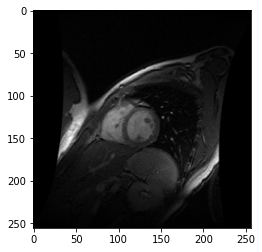

In [3]:
#%% SECTION 2 - Lecture de l'image

im = skio.imread('coeurIRM.bmp')

#im = skio.imread('retineOA.bmp')

#im = skio.imread('brain.bmp')
#im = im[:,:,1]

#im = skio.imread('brain2.bmp')

plt.imshow(im, cmap="gray")

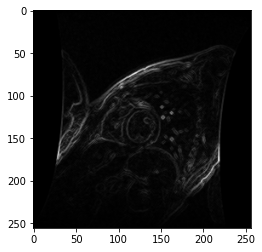

In [4]:
from skimage.morphology import disk
from skimage.filters.rank import gradient
plt.imshow(gradient(im, disk(1)), cmap='gray')

# Méthode des Contours Actifs Paramétriques

J'ai utilisé la méthode des contours actifs paramétriques pour segmenter une image du coeur et une image de la rétine. On peut voir ci-dessous les résultats obtenus.
 
Cette méthode utilise plusieurs hyperparamètres :
 
* une image, qu'on passe par un filtre gaussien pour la lisser et éviter que l'énergie converge vers un minimum local ;
* un ensemble des points initiaux pour la *snake* (la *snake* de sortie aura la même taille que celle-là, donc il faut bien choisir le numéro de points pour bien capturer le contour) ;
* alpha, le paramètre qui contrôle la contraction de la *snake*, et beta, qui contrôle son lissage. Une valeur grande de α pénalise la distance entre les points du contour, et une valeur grande de β pénalise les oscillations du contour ;
* w_edge controlle l'attraction aux bords. Si la valeur est négative, la *snake* sera repoussée des bords. Pour le cas de la segmentation du coeur, j'ai utilisé une valeur négative parce que les bords externes (entre le corps et l'arrière-plan) sont beaucoup plus forts que les bords du coeur ;
* gamma est le *step time*, si on change le *step time* de l'algorithme on peut avoir des résultats très différents.
 
Pour la segmentation de la rétine, j'ai changé aussi les paramètres *w_line* et *boundary conditions* :
* *boundary conditions* contrôle la relation entre le point initial et le point final du contour. Par défaut ce paramètre est "periodic", c'est-à-dire le serpent est fini où il a commencé. Pour la rétine, on utilise "free" : ces deux points ne sont pas attachés, et ils ont certaine liberté pour se positionner autour des positions données pour mieux s'adapter au contour ;
* w_line contrôle l'attraction aux régions claires. Comme la rétine est une ligne blanche au milieu des lignes noires, c'est bon de donner une valeur haute à ce paramètre dans ce cas.
 
Les résultats sont bons (comme on peut voir dans les images suivantes), mais il a fallu essayer plusieurs combinaisons de paramètres pour trouver une bonne segmentation, ce qui rendre la méthode un peu manuelle (un inconvénient de cette méthode).

Une amélioration possible pour ces méthodes est l'inclusion de contraintes comme la force de ballon, qui fait que le serpent ne soit pas attiré aux bords distants, entre autres effets.



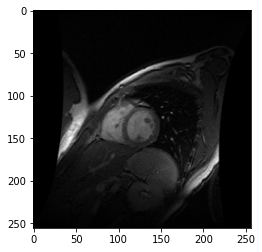

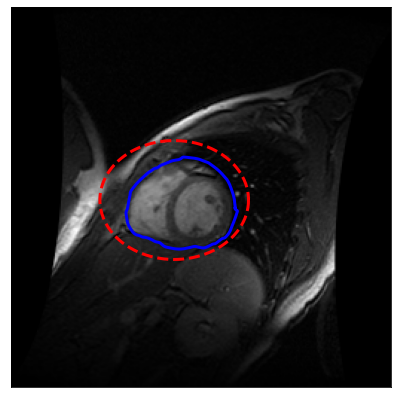

In [32]:
#%% SECTION 3a - Segmentation by contours actifs

im = skio.imread('coeurIRM.bmp')
plt.imshow(im, cmap='gray')

s = np.linspace(0, 2*np.pi, 200)
r = 130 + 40*np.sin(s)
c = 110 + 50*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(im, 0.1),
                       init, alpha=0.8, beta=1, w_edge=-2, gamma=0.001)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

s = np.linspace(0, 2*np.pi, 200)
r = 130 + 40*np.sin(s)
c = 110 + 50*np.cos(s)
init = np.array([r, c]).T
plt.show()

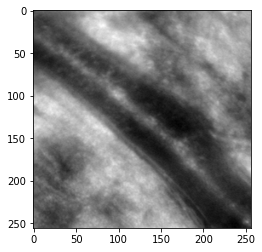

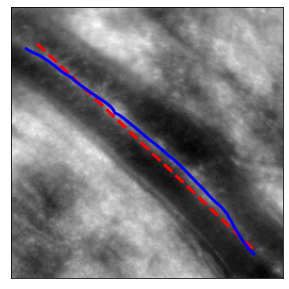

In [6]:
#%% SECTION 3b - Contours ouverts

im = skio.imread('retineOA.bmp')

plt.imshow(im, cmap='gray')

# Interessant sur l'image retineOA.bmp

r = np.linspace(35, 230, 100)
c = np.linspace(25, 230, 100)
init = np.array([r, c]).T

snake = active_contour(gaussian(im, 1), init, boundary_condition='free', 
                       alpha=0.5, beta=5, w_line=20, w_edge=20, gamma=0.01)

fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

# Méthode de Chan et Vese

La méthode de Chan et Vese utilise des ensembles de niveaux de gris pour segmenter l'image en cherchant de minimiser une énergie. Les hyperparamètres sont :

* L'image qu'on veut segmenter ;
* Une valeur μ (longueur du bord). Si la valeur est trop grande on pénalise les bords petits, donc on n'arrive pas a détecter des pétites regions. Comme le cerveau est une grosse région, on peut utiliser un paramètre μ proche de 1 ;
* Les poids λ1 et λ2 pour les régions de la sortie de valeur True et False, réspectivement. Le lambda avec la valeur le plus petite est celui qu'aura l'intervalle des valeurs le plus grand. Comme on veut segmenter les parties du cerveau, j'ai choisi un λ1 plus petit que λ2 ;
* tol et max_iter fournissent la condition d'arrête de l'algorithm (il peut s'arrêter parce qu'il a atteint la tolérance nécessaire ou, sinon, parce qu'il a atteint un numéro suffisament grand d'itérations ;
* initial_level_set est la définition de l'ensemble de niveaux utilisé au début de l'algorithm. La géometrie de l'ensemble utilisé influence la vitesse de convergence et la capacité de la méthode de détecter des contours implicites. On peut voir, par exemple, que si on utilise un "checkboard" il y a des fausses contours autour du cerveau. 

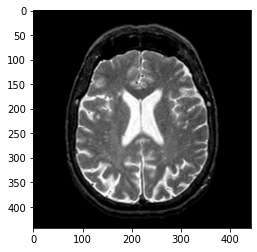

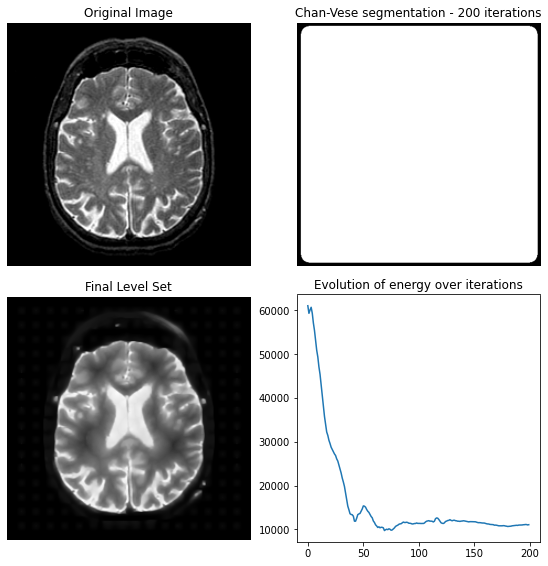

In [73]:
#%% SECTION 4 - Segmentation par ensembles de niveaux

im = skio.imread('brain.bmp')
im = im[:,:,1]
plt.imshow(im, cmap='gray')

#im = skio.imread('retineOA.bmp')
image = img_as_float(im)

# Init avec plusieurs cercles
circleNum = 16
circleRadius = image.shape[0] / (3*circleNum)
circleStep0 = image.shape[0]/(circleNum+1)
circleStep1 = image.shape[1]/(circleNum+1)
init_ls = np.zeros(image.shape)
for i in range(circleNum):
  for j in range(circleNum):
    init_ls = init_ls + disk_level_set(image_shape=image.shape, center=((i+1)*circleStep0, (j+1)*circleStep1), radius=circleRadius)

# Init avec un damier
#init_ls = checkerboard_level_set(image.shape, 6)

# Init avec un cercle
#init_ls = circle_level_set (image.shape, (221,221), 50)

cv = chan_vese(image, mu=1, lambda1=1, lambda2=10, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set=init_ls, extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()
     
#%% FIN  TP - Modeles deformables